In [44]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.optimize import brentq as find_root
from scipy.spatial import Delaunay
from tqdm import tqdm

## Load in and calculate depths for CE09

In [45]:
DATA_DIRECTORY = Path("../data")
CE09_OSPM_FILE = DATA_DIRECTORY / "ce09ospm_gridded_profiles.nc"
MLD_THRESHOLD = 0.1  # kg/m3
SIGMA_LAYER = 25.8  # kg/m3

ce09 = xr.open_dataset(CE09_OSPM_FILE)
ce09 = ce09.squeeze().load()
ce09 = ce09.swap_dims({"pressure": "depth"})
# backfill surface data for identifying surface sigma_0, but limit to 5 m depth (10 data points at 0.5 m intervals)
ce09_bfill = ce09.bfill("depth", limit=10)
ce09["threshold_sigma_0"] = ce09_bfill["potential_density"].isel(depth=0) + MLD_THRESHOLD

In [46]:
def calculate_mld(depth: np.ndarray, z: np.ndarray, sigma_0: np.ndarray, surface_sigma_0: float) -> float:
    """Calculate mixed layer depth for a single time step.

    Args:
        depth (np.ndarray): Array of depths at which to calculate the mixed layer depth.
        z (np.ndarray): Array of depths corresponding to sigma_0.
        sigma_0 (np.ndarray): Array of sigma_0 values.
        surface_sigma_0 (float): Surface sigma_0 value.

    Returns:
        float: Mixed layer depth.

    """
    mld = np.interp(depth, z, sigma_0, left=np.nan, right=np.nan) - surface_sigma_0
    return float(mld)


mld = np.empty(ce09["time"].size) * np.nan
sigma_layer_depth = np.empty(ce09["time"].size) * np.nan

for i, (sigma_0, surface_sigma_0) in enumerate(
    zip(
        ce09["potential_density"].isel(depth=slice(None)).to_numpy().T,
        ce09["threshold_sigma_0"].to_numpy(),
        strict=True,
    ),
):
    z = ce09["depth"].to_numpy()[~np.isnan(sigma_0)]
    sigma_0_filtered = sigma_0[~np.isnan(sigma_0)]
    try:
        mld[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=surface_sigma_0,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        mld[i] = np.nan
    try:
        sigma_layer_depth[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=SIGMA_LAYER,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        sigma_layer_depth[i] = np.nan

sigma_at_mld = ce09["potential_density"].interp(depth=xr.DataArray(mld, dims="time"))

c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:588: RuntimeWarning: All-NaN axis encountered
  minval = np.nanmin(new_x_loaded)
c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:589: RuntimeWarning: All-NaN axis encountered
  maxval = np.nanmax(new_x_loaded)


## Load in model results

In [15]:
MODEL_PATH = Path("D:/avg")

isopycnal_25_8_depth = xr.open_zarr(MODEL_PATH / "isopycnal_depth_25.8.zarr")
mixed_layer_depth = xr.open_zarr(MODEL_PATH / "mixed_layer_depth_delta_sigma_0.1.zarr")
density_at_mld = xr.open_zarr(MODEL_PATH / "density_at_mld_delta_sigma_0.1.zarr")

# Haven't yet implemented a dask version of this, so for now can only use a couple hundred points
pnw_coords = {"eta_rho": slice(700, 900), "xi_rho": slice(500, 700)}

mixed_layer_depth = mixed_layer_depth.transpose("time", "eta_rho", "xi_rho").isel(**pnw_coords)  # pyright: ignore[reportArgumentType]; this works as intended
isopycnal_25_8_depth = isopycnal_25_8_depth.transpose("time", "eta_rho", "xi_rho").isel(**pnw_coords)  # pyright: ignore[reportArgumentType]; this works as intended
density_at_mld = density_at_mld.transpose("time", "eta_rho", "xi_rho").isel(**pnw_coords)  # pyright: ignore[reportArgumentType]; this works as intended

## Grid model data onto regular grid for interpolation

In [ ]:
def build_barycentric_weights(
    lon: np.ndarray,
    lat: np.ndarray,
    target_lon: np.ndarray,
    target_lat: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """Build triangulation once and compute barycentric weights for each target point.

    Args:
        lon (np.ndarray): 2D array of longitudes of the grid points.
        lat (np.ndarray): 2D array of latitudes of the grid points.
        target_lon (np.ndarray): 1D array of target longitudes.
        target_lat (np.ndarray): 1D array of target latitudes.

    Returns:
        tuple[np.ndarray, np.ndarray]: vertices and weights for interpolation.

    """
    pts = np.column_stack((lon.ravel(), lat.ravel()))
    tri = Delaunay(pts)

    # Target points
    tgt = np.column_stack((target_lon, target_lat))

    # Find triangle for each target point
    simplex = tri.find_simplex(tgt)

    # Compute barycentric coordinates
    w0 = tri.transform[simplex, :2]  # affine transform matrix
    w1 = tgt - tri.transform[simplex, 2]  # shift
    bary = np.einsum("ijk,ik->ij", w0, w1)  # this is w0 @ w1 for each triangle
    weights = np.c_[bary, 1 - bary.sum(axis=1)]  # weights sum to 1, so calculate 3rd from the first 2

    # Extract the 3 vertex indices for each target location
    vertices = tri.simplices[simplex]

    # Remove points outside grid triangulation
    weights[simplex == -1] = np.nan

    return vertices, weights


def _interp_slice(field2d: np.ndarray, vertices: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """Interpolate one 2D field using precomputed vertices & weights.

    Args:
        field2d (np.ndarray): 2D array of field values to interpolate.
        vertices (np.ndarray): Indices of the triangle vertices for each target point.
        weights (np.ndarray): Barycentric weights for each target point.

    Returns:
        np.ndarray: Interpolated values at target points.

    """
    flat_field = field2d.ravel()
    # Get field values at vertices
    flat_field_verts = flat_field[vertices]
    # Calculate interpolated value
    return np.sum(flat_field_verts * weights, axis=1)


def interpolate_timeseries(  # noqa: PLR0913
    var: np.ndarray,
    lon: np.ndarray,
    lat: np.ndarray,
    target_lon: np.ndarray,
    target_lat: np.ndarray,
    vertices: np.ndarray | None = None,
    weights: np.ndarray | None = None,
) -> np.ndarray:
    """Interpolate a 3D variable var[time, eta, xi] onto target locations.

    Args:
        var (np.ndarray): 3D array of variable to interpolate.
        lon (np.ndarray): 2D array of longitudes of the grid points.
        lat (np.ndarray): 2D array of latitudes of the grid points.
        target_lon (np.ndarray): 1D array of target longitudes.
        target_lat (np.ndarray): 1D array of target latitudes.
        vertices (np.ndarray | None, optional): Precomputed vertices for interpolation. If None, they will be computed.
        weights (np.ndarray | None, optional): Precomputed weights for interpolation. If None, they will be computed.

    Returns:
        np.ndarray: Interpolated variable at target locations with shape (time, nlat, nlon).

    """
    nlon = target_lon.size
    nlat = target_lat.size

    target_lon, target_lat = np.meshgrid(target_lon, target_lat)
    target_lon = target_lon.ravel()
    target_lat = target_lat.ravel()

    if weights is None or vertices is None:
        vertices, weights = build_barycentric_weights(lon, lat, target_lon, target_lat)

    nt = var.shape[0]

    out = np.empty((nt, target_lon.size), dtype=float)

    # 3. Loop over time slices (very fast)
    for t in tqdm(range(nt)):
        out[t] = _interp_slice(var[t], vertices, weights)

    return out.reshape(nt, nlat, nlon)

In [ ]:
# 0.05 degree grid (~5 km)
target_lon = np.arange(mixed_layer_depth["lon_rho"].min(), mixed_layer_depth["lon_rho"].max(), 0.05)
target_lat = np.arange(mixed_layer_depth["lat_rho"].min(), mixed_layer_depth["lat_rho"].max(), 0.05)

gridded_mld = interpolate_timeseries(
    mixed_layer_depth["depth"].to_numpy(),
    mixed_layer_depth["lon_rho"].to_numpy(),
    mixed_layer_depth["lat_rho"].to_numpy(),
    target_lon,
    target_lat,
)
gridded_isopycnal_25_8_depth = interpolate_timeseries(
    isopycnal_25_8_depth["depth"].to_numpy(),
    isopycnal_25_8_depth["lon_rho"].to_numpy(),
    isopycnal_25_8_depth["lat_rho"].to_numpy(),
    target_lon,
    target_lat,
)
gridded_density_at_mld = interpolate_timeseries(
    density_at_mld["density"].to_numpy(),
    density_at_mld["lon_rho"].to_numpy(),
    density_at_mld["lat_rho"].to_numpy(),
    target_lon,
    target_lat,
)

100%|██████████| 2807/2807 [00:00<00:00, 4736.12it/s]


In [ ]:
model = xr.Dataset(
    {
        "mld": (["time", "lat", "lon"], gridded_mld),
        "isopycnal_depth": (["time", "lat", "lon"], gridded_isopycnal_25_8_depth),
        "density_at_mld": (["time", "lat", "lon"], gridded_density_at_mld),
    },
    coords={"time": mixed_layer_depth["time"], "lat": target_lat, "lon": target_lon},
)
model

<xarray.Dataset> Size: 561MB
Dimensions:          (time: 2807, lat: 75, lon: 111)
Coordinates:
  * time             (time) datetime64[ns] 22kB 1979-12-30 ... 1992-04-20
  * lat              (lat) float64 600B 45.42 45.47 45.52 ... 49.02 49.07 49.12
  * lon              (lon) float64 888B -128.2 -128.1 -128.1 ... -122.7 -122.7
Data variables:
    mld              (time, lat, lon) float64 187MB nan -42.1 -42.03 ... nan nan
    isopycnal_depth  (time, lat, lon) float64 187MB nan -86.47 ... nan nan
    density_at_mld   (time, lat, lon) float64 187MB nan 24.58 24.58 ... nan nan

## Interpolate to get model data at CE09

In [66]:
model = model.sortby("time")

In [67]:
model_at_ce09 = model.interp(lon=ce09["longitude"] - 360, lat=ce09["latitude"])

In [86]:
model_at_ce09["mld"] - model_at_ce09["isopycnal_depth"]

<xarray.DataArray (time: 2807)> Size: 22kB
array([52.26203227, 50.8547553 , 44.96982002, ..., 98.06827683,
       96.79776516, 99.3680194 ], shape=(2807,))
Coordinates:
  * time       (time) datetime64[ns] 22kB 1979-12-30 1980-01-04 ... 2018-05-29
    lon        float32 4B -125.0
    lat        float32 4B 46.85
    latitude   float32 4B 46.85
    longitude  float32 4B 235.0

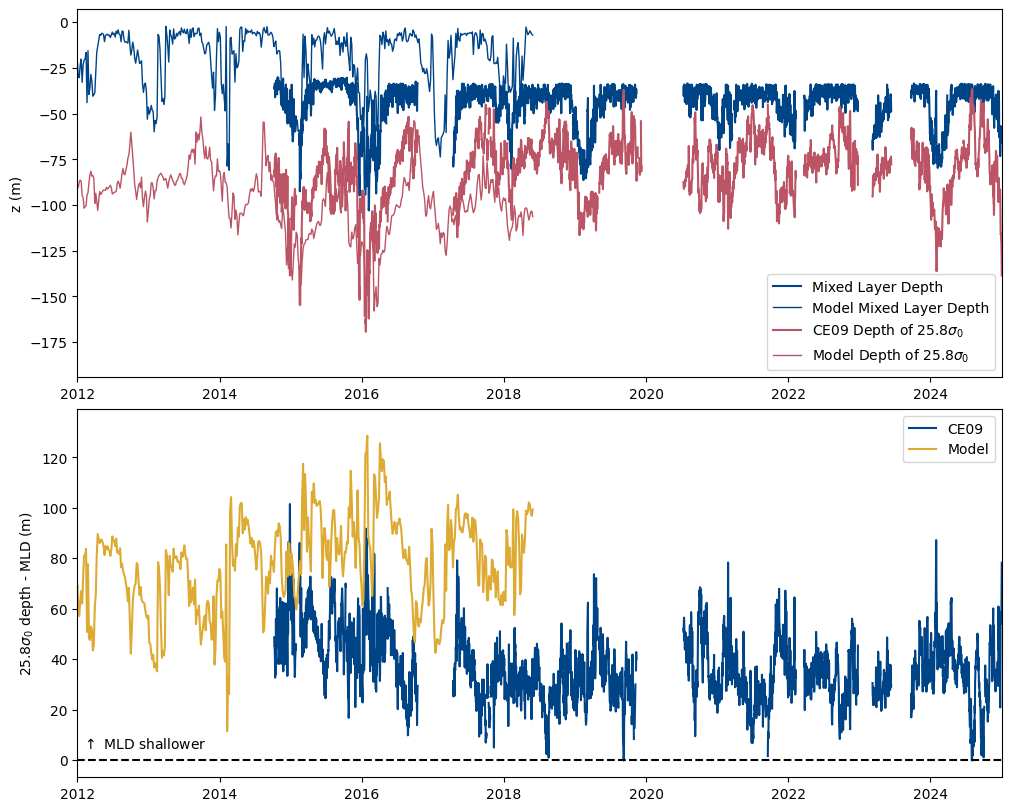

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained")
ax1: plt.Axes = axs[0]
ax2: plt.Axes = axs[1]
xlim = (np.datetime64("2012-01-01"), np.datetime64("2025-01-01"))


ax1.plot(ce09["time"], -mld, label="Mixed Layer Depth", c="#004488")
ax1.plot(model_at_ce09["time"], model_at_ce09["mld"], label="Model Mixed Layer Depth", c="#004488", lw=1)
ax1.plot(ce09["time"], -sigma_layer_depth, label=f"CE09 Depth of {SIGMA_LAYER}$\\sigma_0$", c="#BB5566")
ax1.plot(
    model_at_ce09["time"],
    model_at_ce09["isopycnal_depth"],
    label=f"Model Depth of {SIGMA_LAYER}$\\sigma_0$",
    c="#BB5566",
    lw=1,
)
ax1.set_xlim(*xlim)
ax1.set_ylabel("z (m)")
ax1.legend()

ax2.plot(ce09["time"], sigma_layer_depth - mld, c="#004488", label="CE09")
ax2.plot(model_at_ce09["time"], model_at_ce09["mld"] - model_at_ce09["isopycnal_depth"], c="#DDAA33", label="Model")
ax2.set_xlim(*xlim)
ax2.legend()

ax2.set_ylabel(f"{SIGMA_LAYER}$\\sigma_0$ depth - MLD (m)")
ax2.annotate(
    "$\\uparrow$ MLD shallower",
    xy=(0.005, 0.08),
    xycoords="axes fraction",
    ha="left",
)
ax2.axhline(0, color="k", linestyle="--")

plt.savefig("../misc/model_wa_profiler_comparison_mld_sigma_layer_depth.png", dpi=300)

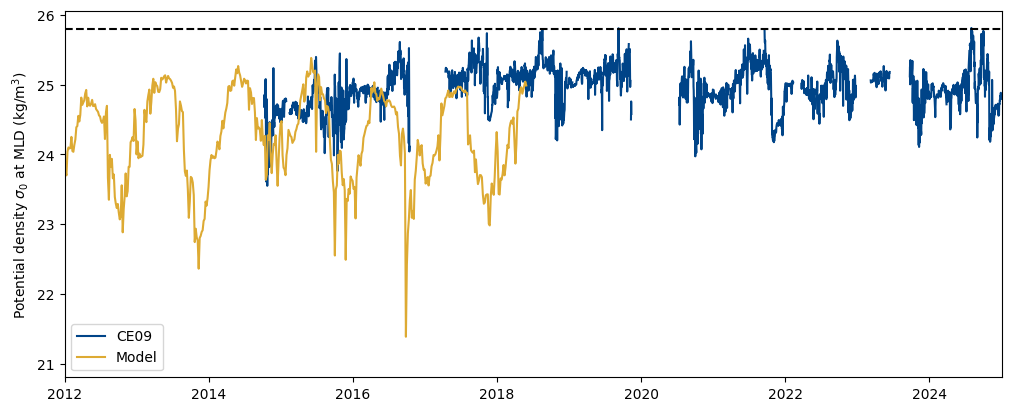

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout="constrained")

ax.plot(ce09["time"], sigma_at_mld, c="#004488", label="CE09")
ax.plot(model_at_ce09["time"], model_at_ce09["density_at_mld"], c="#DDAA33", label="Model")
ax.set_ylabel("Potential density $\\sigma_0$ at MLD (kg/m$^3$)")
ax.axhline(SIGMA_LAYER, color="k", linestyle="--")
ax.set_xlim(*xlim)  # ty: ignore[invalid-argument-type]
ax.legend()

plt.savefig("../misc/model_wa_profiler_comparison_sigma_at_mld.png", dpi=300)